# Find published articles missing from bioRxiv

In [1]:
from pathlib import Path
import pickle

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotnine as p9
from scipy.spatial.distance import cdist
import scipy.stats
import seaborn as sns
from sklearn.linear_model import LogisticRegressionCV
import tqdm

# Load Embeddings

## bioRxiv

In [2]:
biorxiv_journal_df = (
    pd.read_csv(
        "../journal_tracker/output/mapped_published_doi_before_update.tsv", sep="\t"
    )
    .rename(index=str, columns={"doi": "preprint_doi"})
    .groupby("preprint_doi")
    .agg(
        {
            "document": "last",
            "category": "first",
            "preprint_doi": "last",
            "published_doi": "first",
            "pmcid": "first",
            "pmcoa": "first",
        }
    )
    .reset_index(drop=True)
)
biorxiv_journal_df.head()

,document,category,preprint_doi,published_doi,pmcid,pmcoa
0,000026_v1.xml,genetics,10.1101/000026,10.1371/journal.pgen.1004412,PMC4125079,True
1,000042_v2.xml,genomics,10.1101/000042,10.1038/nrg3723,PMC4151119,False
2,000067_v1.xml,genomics,10.1101/000067,10.1038/nature12904,PMC4285441,True
3,000091_v1.xml,synthetic biology,10.1101/000091,NaN,NaN,False
4,000109_v1.xml,evolutionary biology,10.1101/000109,10.1371/journal.pgen.1004410,PMC4072524,True


In [3]:
biorxiv_embed_df = pd.read_csv(
    Path("../word_vector_experiment/output/")
    / "word2vec_output/"
    / "biorxiv_all_articles_300_abstract_only.tsv.xz",
    sep="\t",
)
biorxiv_embed_df = biorxiv_embed_df.dropna()
biorxiv_embed_df.head()

,document,feat_0,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,feat_8,...,feat_290,feat_291,feat_292,feat_293,feat_294,feat_295,feat_296,feat_297,feat_298,feat_299
0,440735_v1.xml,0.049683,-0.005313,-0.280530,-0.400511,0.195028,-0.457895,0.071152,-0.271122,0.870192,...,-0.159798,-0.093165,-0.020038,-0.256331,-0.831966,-0.113250,0.740653,0.783240,-0.055414,-0.056756
1,775270_v1.xml,-0.524199,-0.177453,-0.305204,-0.414987,0.364863,-0.555063,-0.360783,0.354435,1.153685,...,-0.201194,-0.355333,0.209096,-0.200741,-0.796939,-0.369679,0.322974,1.070569,-0.738358,-0.013017
2,242404_v1.xml,-0.429192,-0.194068,0.164302,0.059272,0.232252,-0.401509,-0.174079,-0.262498,0.369619,...,-0.217306,-0.281388,-0.133783,-0.347076,-0.808194,-0.446992,0.487214,0.971813,-0.109935,-0.021412
3,872994_v1.xml,-0.542733,-0.150380,-0.148665,0.183456,0.811360,-0.018211,-0.456181,-0.443373,0.918530,...,0.272817,-0.060654,0.100888,0.161495,-0.654617,-0.316284,0.703039,0.656463,-0.775197,-0.274302
4,080853_v2.xml,0.088444,-0.137297,-0.896437,-0.233166,-0.278498,-0.550895,-0.336696,0.521426,0.675406,...,1.062681,0.762903,0.001390,0.385186,-0.900015,-0.343282,0.052107,0.437099,-0.009503,0.506388


In [4]:
biorxiv_journal_mapped_df = biorxiv_journal_df[
    ["document", "published_doi", "pmcid", "pmcoa"]
].merge(biorxiv_embed_df, on="document")
biorxiv_journal_mapped_df.head()

,document,published_doi,pmcid,pmcoa,feat_0,feat_1,feat_2,feat_3,feat_4,feat_5,...,feat_290,feat_291,feat_292,feat_293,feat_294,feat_295,feat_296,feat_297,feat_298,feat_299
0,000026_v1.xml,10.1371/journal.pgen.1004412,PMC4125079,True,-0.298982,-0.078562,-0.003997,-0.431904,0.459007,-0.381755,...,-0.187987,-0.308529,-0.273841,-0.040498,-1.093170,-0.821947,0.557226,1.284185,0.252782,-0.200204
1,000042_v2.xml,10.1038/nrg3723,PMC4151119,False,-0.442419,-0.306251,-0.087155,-0.407616,-0.068069,-0.369523,...,-0.158311,0.331435,-0.129121,-0.276922,-0.675032,-0.019032,0.705792,0.699059,-0.203919,-0.121826
2,000067_v1.xml,10.1038/nature12904,PMC4285441,True,-0.191464,0.141381,0.002216,-0.869190,0.119849,-0.425510,...,0.196109,-0.060955,-0.262037,0.118481,-0.951357,-0.842017,1.098037,0.863589,0.144519,0.382255
3,000091_v1.xml,NaN,NaN,False,-0.436908,-0.101085,-0.099482,-0.073992,0.694067,-0.615465,...,0.165388,-0.324982,0.657206,0.356909,-0.282777,-0.296238,0.615122,0.604242,-0.394435,0.012084
4,000109_v1.xml,10.1371/journal.pgen.1004410,PMC4072524,True,-0.234032,0.017568,0.022168,-0.271829,-0.132478,0.247507,...,0.293751,0.365982,-0.030464,-0.210917,-0.890332,-0.697331,0.392546,1.228314,0.115065,0.320773


## Pubmed Central

In [5]:
pmc_articles_df = pd.read_csv(
    Path("../../pmc/exploratory_data_analysis/")
    / "output/pubmed_central_journal_paper_map.tsv.xz",
    sep="\t",
).query("article_type=='research-article'")
pmc_articles_df.head()

,journal,article_type,doi,pmcid
0,Environ_Health,research-article,10.1186/1476-069X-5-22,PMC1552054
1,Environ_Health,research-article,10.1186/1476-069X-4-12,PMC1226148
3,Environ_Health,research-article,10.1186/s12940-017-0316-3,PMC5635510
4,Environ_Health,research-article,10.1186/1476-069X-10-46,PMC3125232
5,Environ_Health,research-article,10.1186/1476-069X-11-91,PMC3533997


In [6]:
pmc_embed_df = pd.read_csv(
    Path("../../pmc/word_vector_experiment/output")
    / Path("pmc_document_vectors_300_abstract_only.tsv.xz"),
    sep="\t",
)
pmc_embed_df.head()

,journal,document,feat_0,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,...,feat_290,feat_291,feat_292,feat_293,feat_294,feat_295,feat_296,feat_297,feat_298,feat_299
0,Environ_Health,PMC1552054,-0.082495,0.133615,-0.128666,-0.158297,-0.742925,-0.341613,0.397725,-0.364350,...,0.031408,-0.267943,-0.199443,-0.858774,-1.192169,-0.569980,0.253509,0.774405,-0.833438,-0.095281
1,Environ_Health,PMC1226148,-0.339266,-0.004717,-0.094548,0.277504,-0.399563,-0.223374,-0.012323,0.177106,...,0.272430,-0.418724,0.321997,-0.431104,-0.560488,-0.506686,0.084024,0.501745,-0.822665,-0.137623
2,Environ_Health,PMC5635510,0.036502,0.098784,0.154018,0.326998,0.056839,-0.490772,-0.025348,-0.008770,...,-0.000010,-0.385773,-0.005046,-0.370977,-0.803896,-0.426593,0.519772,0.713822,-0.352837,-0.250790
3,Environ_Health,PMC3125232,-0.044949,0.106693,-0.093076,-0.209152,0.098663,-0.404548,-0.223798,-0.288635,...,-0.200652,-0.337646,0.129428,-0.570364,-1.039630,-0.600701,0.169035,0.735212,-0.439475,-0.307847
4,Environ_Health,PMC3533997,0.018855,0.203776,-0.056129,0.142956,-0.280374,-0.453074,0.223539,-0.102403,...,-0.096542,-0.539100,-0.119428,-0.629232,-0.950591,-0.270683,0.035700,0.831872,-0.697333,-0.192185


In [7]:
pmc_journal_mapped_df = (
    pmc_articles_df[["doi", "pmcid"]]
    .merge(pmc_embed_df, left_on="pmcid", right_on="document")
    .drop("pmcid", axis=1)
)
pmc_journal_mapped_df.head()

,doi,journal,document,feat_0,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,...,feat_290,feat_291,feat_292,feat_293,feat_294,feat_295,feat_296,feat_297,feat_298,feat_299
0,10.1186/1476-069X-5-22,Environ_Health,PMC1552054,-0.082495,0.133615,-0.128666,-0.158297,-0.742925,-0.341613,0.397725,...,0.031408,-0.267943,-0.199443,-0.858774,-1.192169,-0.569980,0.253509,0.774405,-0.833438,-0.095281
1,10.1186/1476-069X-4-12,Environ_Health,PMC1226148,-0.339266,-0.004717,-0.094548,0.277504,-0.399563,-0.223374,-0.012323,...,0.272430,-0.418724,0.321997,-0.431104,-0.560488,-0.506686,0.084024,0.501745,-0.822665,-0.137623
2,10.1186/s12940-017-0316-3,Environ_Health,PMC5635510,0.036502,0.098784,0.154018,0.326998,0.056839,-0.490772,-0.025348,...,-0.000010,-0.385773,-0.005046,-0.370977,-0.803896,-0.426593,0.519772,0.713822,-0.352837,-0.250790
3,10.1186/1476-069X-10-46,Environ_Health,PMC3125232,-0.044949,0.106693,-0.093076,-0.209152,0.098663,-0.404548,-0.223798,...,-0.200652,-0.337646,0.129428,-0.570364,-1.039630,-0.600701,0.169035,0.735212,-0.439475,-0.307847
4,10.1186/1476-069X-11-91,Environ_Health,PMC3533997,0.018855,0.203776,-0.056129,0.142956,-0.280374,-0.453074,0.223539,...,-0.096542,-0.539100,-0.119428,-0.629232,-0.950591,-0.270683,0.035700,0.831872,-0.697333,-0.192185


# Calculate Distances

## biorxiv -> published versions

In [8]:
biorxiv_published = (
    biorxiv_journal_mapped_df.query("pmcid.notnull()")
    .query("pmcoa == True")
    .sort_values("pmcid", ascending=True)
    .drop_duplicates("pmcid")
    .set_index("pmcid")
)
biorxiv_published.head()

,document,published_doi,pmcoa,feat_0,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,...,feat_290,feat_291,feat_292,feat_293,feat_294,feat_295,feat_296,feat_297,feat_298,feat_299
pmcid,,,,,,,,,,,,,,,,,,,,,
PMC3585962,000380_v1.xml,10.1016/j.biochi.2012.05.024,True,0.090547,0.306810,-0.616009,-0.837763,0.070825,-0.240500,-0.415827,...,0.847852,0.316998,0.095507,-0.218709,-1.125300,-0.621611,0.641706,0.386450,-0.171495,-0.243176
PMC3866385,000968_v1.xml,10.3389/fnhum.2013.00880,True,-0.192975,0.135193,-0.098361,0.360366,0.248848,-0.382827,-0.368584,...,-0.344232,-0.449493,0.290952,0.174506,-0.956047,-0.053821,1.284888,0.490508,-0.395797,-0.303167
PMC3893193,001297_v2.xml,10.1371/journal.pone.0085203,True,-0.078099,-0.416664,-0.262605,0.331034,0.587252,-0.281578,-0.465551,...,0.159381,0.056271,0.387154,0.356957,-0.698840,-0.706851,0.836242,1.288470,-0.462127,-0.121378
PMC3894166,000141_v1.xml,10.1371/journal.pcbi.1003433,True,-0.479438,0.056296,-0.691824,-0.301819,0.087331,-0.568893,-0.256237,...,0.619415,0.258971,0.002456,0.279156,-0.823364,-0.485138,0.352549,0.737440,-0.009953,-0.130214
PMC3906208,000315_v1.xml,10.1371/journal.pone.0087782,True,0.230431,0.205749,-0.287805,-0.501893,-0.296155,-0.373437,0.295377,...,0.613763,0.798160,-0.381281,0.307979,-0.791674,0.116789,0.641568,0.571840,0.057430,-0.004923


In [9]:
PMC_published = (
    pmc_journal_mapped_df.query(f"document in {biorxiv_published.index.tolist()}")
    .sort_values("document", ascending=True)
    .set_index("document")
)
PMC_published.head()

,doi,journal,feat_0,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,...,feat_290,feat_291,feat_292,feat_293,feat_294,feat_295,feat_296,feat_297,feat_298,feat_299
document,,,,,,,,,,,,,,,,,,,,,
PMC3585962,10.1016/j.biochi.2012.05.024,Biochimie,0.113132,0.309231,-0.562484,-0.796993,0.046406,-0.252489,-0.422312,-0.186689,...,0.804182,0.278841,0.092468,-0.204351,-1.087529,-0.617446,0.635504,0.427031,-0.201825,-0.205316
PMC3866385,10.3389/fnhum.2013.00880,Front_Hum_Neurosci,-0.196276,0.137232,-0.099287,0.364520,0.247361,-0.384291,-0.373917,-0.592327,...,-0.345403,-0.456591,0.296628,0.176222,-0.958276,-0.060655,1.294752,0.487555,-0.392420,-0.302093
PMC3893193,10.1371/journal.pone.0085203,PLoS_One,-0.067363,-0.416990,-0.246344,0.339359,0.572888,-0.270937,-0.460240,-0.110057,...,0.170826,0.056867,0.379227,0.350042,-0.694444,-0.713472,0.838011,1.296732,-0.444024,-0.104856
PMC3894166,10.1371/journal.pcbi.1003433,PLoS_Comput_Biol,-0.472690,0.071937,-0.718546,-0.307451,0.109441,-0.547143,-0.261572,0.600360,...,0.656827,0.270903,0.023321,0.279059,-0.821819,-0.482540,0.342753,0.755744,0.001908,-0.127509
PMC3906208,10.1371/journal.pone.0087782,PLoS_One,0.273846,0.270769,-0.321642,-0.533202,-0.243574,-0.384201,0.293180,0.202655,...,0.600906,0.725096,-0.343176,0.273801,-0.823198,0.034130,0.709428,0.613859,0.051428,-0.032291


In [10]:
article_distances = cdist(
    biorxiv_published.loc[PMC_published.index.tolist()].drop(
        ["document", "published_doi", "pmcoa"], axis=1
    ),
    PMC_published.drop(["doi", "journal"], axis=1),
    "euclidean",
)
article_distances.shape

(17200, 17200)

In [11]:
articles_distance_df = (
    biorxiv_published.loc[PMC_published.index.tolist()]
    .reset_index()[["document", "pmcid"]]
    .assign(
        distance=np.diag(article_distances, k=0), journal=PMC_published.journal.tolist()
    )
)
articles_distance_df.head()

,document,pmcid,distance,journal
0,000380_v1.xml,PMC3585962,0.518868,Biochimie
1,000968_v1.xml,PMC3866385,0.115487,Front_Hum_Neurosci
2,001297_v2.xml,PMC3893193,0.187037,PLoS_One
3,000141_v1.xml,PMC3894166,0.304204,PLoS_Comput_Biol
4,000315_v1.xml,PMC3906208,0.796754,PLoS_One


## biorxiv -> random paper same journal

In [12]:
PMC_off_published = (
    pmc_journal_mapped_df.drop("doi", axis=1)
    .query(f"document not in {biorxiv_published.index.tolist()}")
    .query(f"journal in {articles_distance_df.journal.unique().tolist()}")
    .groupby("journal", group_keys=False)
    .apply(lambda x: x.sample(1, random_state=100))
)
PMC_off_published.head()

,journal,document,feat_0,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,...,feat_290,feat_291,feat_292,feat_293,feat_294,feat_295,feat_296,feat_297,feat_298,feat_299
1818906,ACS_Cent_Sci,PMC6026784,-0.681482,-0.191075,-0.752348,0.086578,0.462990,-0.854228,-0.895747,0.054635,...,-0.043304,-0.112771,0.391860,-0.278340,-0.859543,-0.252730,0.531131,1.135124,-0.261797,-0.278064
1109629,ACS_Chem_Biol,PMC4301073,-0.440268,-0.199558,-0.816160,-0.982007,0.126799,-0.953073,-0.276664,0.191993,...,0.989468,0.265300,0.382045,-0.285129,-0.883561,-0.252172,0.437468,0.596660,-0.756947,0.355078
1860630,ACS_Nano,PMC4790916,-0.012121,-0.178235,-0.651338,-0.137735,0.137867,-0.396495,-0.080668,0.242958,...,0.459250,-0.036975,0.179481,-0.275175,-0.369066,-0.166862,0.268621,0.529154,-0.688742,0.036031
1581055,ACS_Omega,PMC6868605,0.173419,-0.298009,-0.429803,0.471965,-0.037190,-0.410447,-0.433263,-0.056907,...,0.181053,-0.632457,0.188114,-0.170395,-0.310792,-0.058474,0.450727,0.627086,-0.619046,0.108597
493466,ACS_Synth_Biol,PMC4161666,-0.275253,-0.509438,-0.639483,-0.755827,0.371981,-0.653632,-0.476748,0.243300,...,0.462287,0.421053,0.302444,0.254484,-0.578680,0.355956,0.672055,0.117560,-0.061638,0.664654


In [13]:
journal_mapper = {
    journal: col for col, journal in enumerate(PMC_off_published.journal.tolist())
}
list(journal_mapper.items())[0:10]

[('ACS_Cent_Sci', 0),
 ('ACS_Chem_Biol', 1),
 ('ACS_Nano', 2),
 ('ACS_Omega', 3),
 ('ACS_Synth_Biol', 4),
 ('AIDS', 5),
 ('AIDS_Res_Hum_Retroviruses', 6),
 ('AIMS_Genet', 7),
 ('AMB_Express', 8),
 ('APL_Bioeng', 9)]

In [14]:
off_article_dist = cdist(
    biorxiv_published.loc[PMC_published.index.tolist()]
    .drop(["document", "published_doi", "pmcoa"], axis=1)
    .values,
    PMC_off_published.drop(["document", "journal"], axis=1).values,
    "euclidean",
)
off_article_dist.shape

(17200, 912)

In [15]:
data = []
for idx, row in tqdm.tqdm(articles_distance_df.iterrows()):
    if row["journal"] in journal_mapper:
        data.append(
            {
                "document": row["document"],
                "pmcid": (
                    PMC_off_published.query(f"journal=='{row['journal']}'")
                    .reset_index()
                    .document.values[0]
                ),
                "journal": row["journal"],
                "distance": off_article_dist[idx, journal_mapper[row["journal"]]],
            }
        )

17200it [01:41, 169.64it/s]


In [16]:
final_df = articles_distance_df.assign(label="pre_vs_published").append(
    pd.DataFrame.from_records(data).assign(label="pre_vs_random")
)
final_df.head()

,document,pmcid,distance,journal,label
0,000380_v1.xml,PMC3585962,0.518868,Biochimie,pre_vs_published
1,000968_v1.xml,PMC3866385,0.115487,Front_Hum_Neurosci,pre_vs_published
2,001297_v2.xml,PMC3893193,0.187037,PLoS_One,pre_vs_published
3,000141_v1.xml,PMC3894166,0.304204,PLoS_Comput_Biol,pre_vs_published
4,000315_v1.xml,PMC3906208,0.796754,PLoS_One,pre_vs_published


In [17]:
final_df = biorxiv_journal_df[["document", "preprint_doi"]].merge(final_df)
final_df.to_csv(
    "output/annotated_links/article_distances_abstract_only.tsv", sep="\t", index=False
)
final_df.head()

,document,preprint_doi,pmcid,distance,journal,label
0,000026_v1.xml,10.1101/000026,PMC4125079,2.618931,PLoS_Genet,pre_vs_published
1,000026_v1.xml,10.1101/000026,PMC2877733,9.386578,PLoS_Genet,pre_vs_random
2,000067_v1.xml,10.1101/000067,PMC4285441,2.279591,Nature,pre_vs_published
3,000067_v1.xml,10.1101/000067,PMC4877333,8.244795,Nature,pre_vs_random
4,000109_v1.xml,10.1101/000109,PMC4072524,1.689832,PLoS_Genet,pre_vs_published


# Distribution plot

/home/danich1/anaconda3/envs/annorxiver/lib/python3.7/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 6.4 x 4.8 in image.
/home/danich1/anaconda3/envs/annorxiver/lib/python3.7/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: output/figures/biorxiv_article_distance_abstract_only.svg
/home/danich1/anaconda3/envs/annorxiver/lib/python3.7/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 6.4 x 4.8 in image.
/home/danich1/anaconda3/envs/annorxiver/lib/python3.7/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: output/figures/biorxiv_article_distance_abstract_only.png


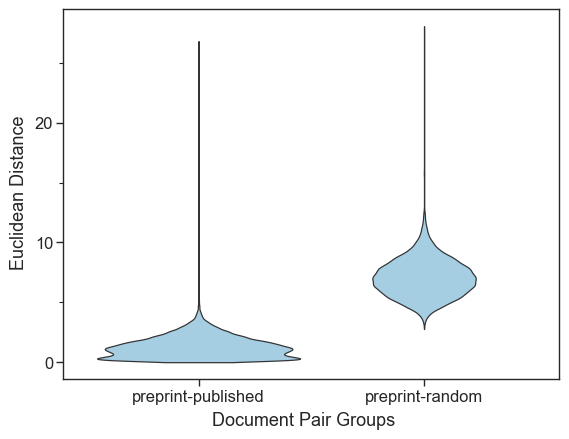

<ggplot: (8788326267561)>


In [18]:
g = (
    p9.ggplot(
        final_df.replace(
            {
                "pre_vs_published": "preprint-published",
                "pre_vs_random": "preprint-random",
            }
        )
    )
    + p9.aes(x="label", y="distance")
    + p9.geom_violin(fill="#a6cee3")
    + p9.labs(x="Document Pair Groups", y="Euclidean Distance")
    + p9.theme_seaborn(context="paper", style="ticks", font="Arial", font_scale=1.35)
)
g.save("output/figures/biorxiv_article_distance_abstract_only.svg", dpi=250)
g.save("output/figures/biorxiv_article_distance_abstract_only.png", dpi=250)
print(g)

# Plot Abstract Only vs Full Text Only

In [19]:
abstract_only = final_df
full_text = pd.read_csv("output/annotated_links/article_distances.tsv", sep="\t")

In [20]:
plot_df = (
    full_text.query("label=='pre_vs_published'")
    .rename(index=str, columns={"distance": "full_text_distance"})[
        ["document", "full_text_distance"]
    ]
    .merge(
        abstract_only.query("label=='pre_vs_published'").rename(
            index=str, columns={"distance": "abstract_only_distance"}
        )[["document", "abstract_only_distance"]],
        on="document",
    )
    # .assign(
    #    abstract_only_distance_log10=lambda x: -np.log10(x.abstract_only_distance),
    #    full_text_distance_log10=lambda x: -np.log10(x.full_text_distance),
    # )
)
plot_df.head()

,document,full_text_distance,abstract_only_distance
0,000026_v1.xml,1.360377,2.618931
1,000067_v1.xml,0.470905,2.279591
2,000109_v1.xml,0.533702,1.689832
3,000141_v1.xml,0.646077,0.304204
4,000158_v1.xml,0.959715,1.555735


In [21]:
# Pearson's R for correlation
# Shows a weak but positive correlation
scipy.stats.pearsonr(plot_df.full_text_distance, plot_df.abstract_only_distance)

(0.2234794046293332, 1.7270407810878488e-193)

/home/danich1/anaconda3/envs/annorxiver/lib/python3.7/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 6.4 x 4.8 in image.
/home/danich1/anaconda3/envs/annorxiver/lib/python3.7/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: output/figures/biorxiv_full_text_v_abstract_only.svg
/home/danich1/anaconda3/envs/annorxiver/lib/python3.7/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 6.4 x 4.8 in image.
/home/danich1/anaconda3/envs/annorxiver/lib/python3.7/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: output/figures/biorxiv_full_text_v_abstract_only.png


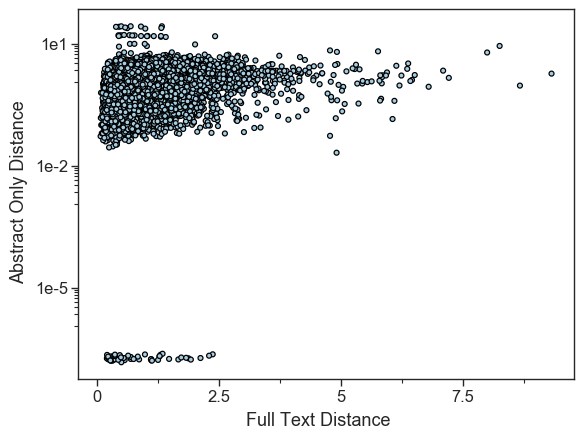

<ggplot: (8788328125809)>


In [22]:
g = (
    p9.ggplot(plot_df)
    + p9.aes(x="full_text_distance", y="abstract_only_distance")
    + p9.geom_point(fill="#a6cee3")
    + p9.scale_y_continuous(trans="log10")
    + p9.labs(x="Full Text Distance", y="Abstract Only Distance")
    + p9.theme_seaborn(context="paper", style="ticks", font="Arial", font_scale=1.35)
)
g.save("output/figures/biorxiv_full_text_v_abstract_only.svg", dpi=250)
g.save("output/figures/biorxiv_full_text_v_abstract_only.png", dpi=250)
print(g)

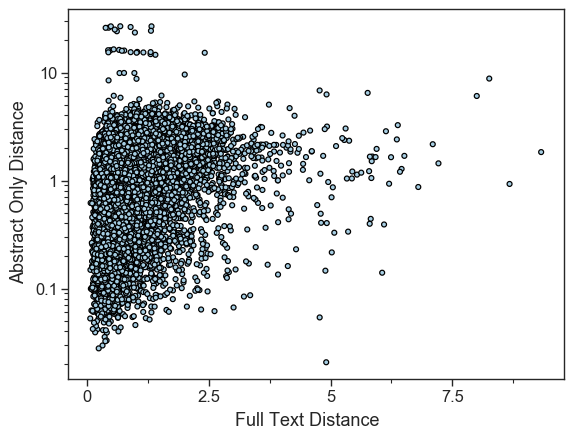

<ggplot: (-9223363248528517814)>


In [23]:
# Remove outliers for shape of distribution
g = (
    p9.ggplot(plot_df.query("abstract_only_distance>1e-3"))
    + p9.aes(x="full_text_distance", y="abstract_only_distance")
    + p9.geom_point(fill="#a6cee3")
    + p9.scale_y_continuous(trans="log10")
    + p9.labs(x="Full Text Distance", y="Abstract Only Distance")
    + p9.theme_seaborn(context="paper", style="ticks", font="Arial", font_scale=1.35)
)
print(g)

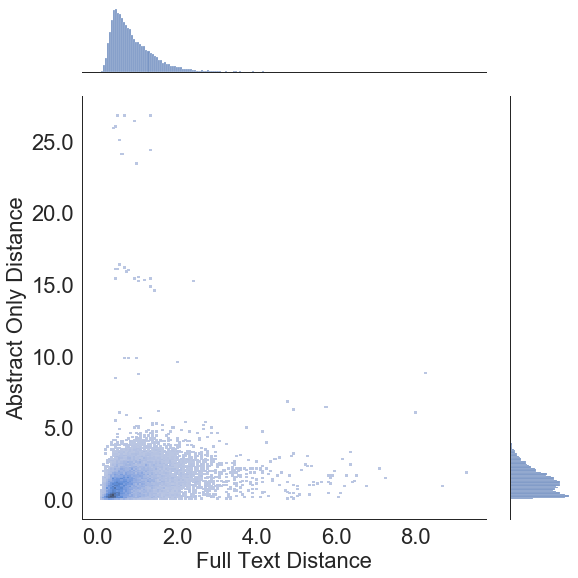

In [24]:
sns.set_theme(
    context="paper", style="white", rc={"figure.figsize": (11, 8.5), "font.size": 22}
)

g = sns.jointplot(
    x=plot_df.full_text_distance,
    y=plot_df.abstract_only_distance,
    kind="hist",
    height=8.5,
)

g.set_axis_labels("Full Text Distance", "Abstract Only Distance", fontsize=22)
g.ax_joint.set_xticklabels(g.ax_joint.get_xticks(), size=22)
g.ax_joint.set_yticklabels(g.ax_joint.get_yticks(), size=22)
plt.tight_layout()

plt.savefig("output/abstract_full_text_histogram_plot.svg")
plt.savefig("output/abstract_full_text_histogram_plot.png", dpi=500)

In [25]:
plot_df.sort_values("abstract_only_distance").head(10)

,document,full_text_distance,abstract_only_distance
6169,203612_v1.xml,0.494929,1.450169e-07
6873,226480_v1.xml,0.279986,1.577786e-07
436,014944_v1.xml,0.314349,1.587705e-07
14438,539882_v1.xml,1.123881,1.593862e-07
16958,743716_v1.xml,0.270527,1.605268e-07
8741,292797_v1.xml,1.112208,1.610426e-07
1847,062745_v1.xml,0.563003,1.637972e-07
1591,053751_v1.xml,1.248363,1.654527e-07
2101,070193_v1.xml,0.306550,1.664683e-07
13515,489013_v1.xml,0.431656,1.664868e-07


In [26]:
plot_df.sort_values("abstract_only_distance", ascending=False).head(10)

,document,full_text_distance,abstract_only_distance
3630,119925_v1.xml,0.686485,26.809098
2372,079996_v2.xml,1.326772,26.766935
3228,107052_v1.xml,0.493276,26.756205
3019,100552_v4.xml,0.897932,26.381321
2803,093856_v1.xml,0.447227,25.996168
7958,264226_v1.xml,0.386197,25.927866
4903,162727_v1.xml,0.573609,24.997384
4738,156869_v1.xml,1.315540,24.340546
309,011072_v1.xml,0.616260,24.095041
3476,114975_v1.xml,0.986399,23.446033


Take Home Points:
1. Abstract only distances are greater than full text as I suspect the vectors generated are susceptible to minor changes compared to full text.
2. Both the abstract only and full text distributions have majority of their distances centered around 0-5
3. Since majority of both distributions are around that way, I'd argue that using abstracts alone could suffice in matching preprints with their published counter parts. By using only abstracts we can detect documents that are published closed access instead of relying full text to be available.
4. The pairs with distances close to zero (abstract only) are practically the same abstract. There might be minor word or phrase changes, but those changes haven't affected the vector much.
5. The points with the highest distance either have a structural change or significant phrase changes.

Feel free to manually check these via [diffchecker](https://www.diffchecker.com) the preprint abstract and its published version.